In [1]:
!python -m pip install xgboost imbalanced-learn seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import xgboost as xgb

In [3]:
df = pd.read_csv('../data/raw/raw_dataset.csv')

# Data Analysis

In [4]:
df.drop(columns=['customer_id'], inplace=True)

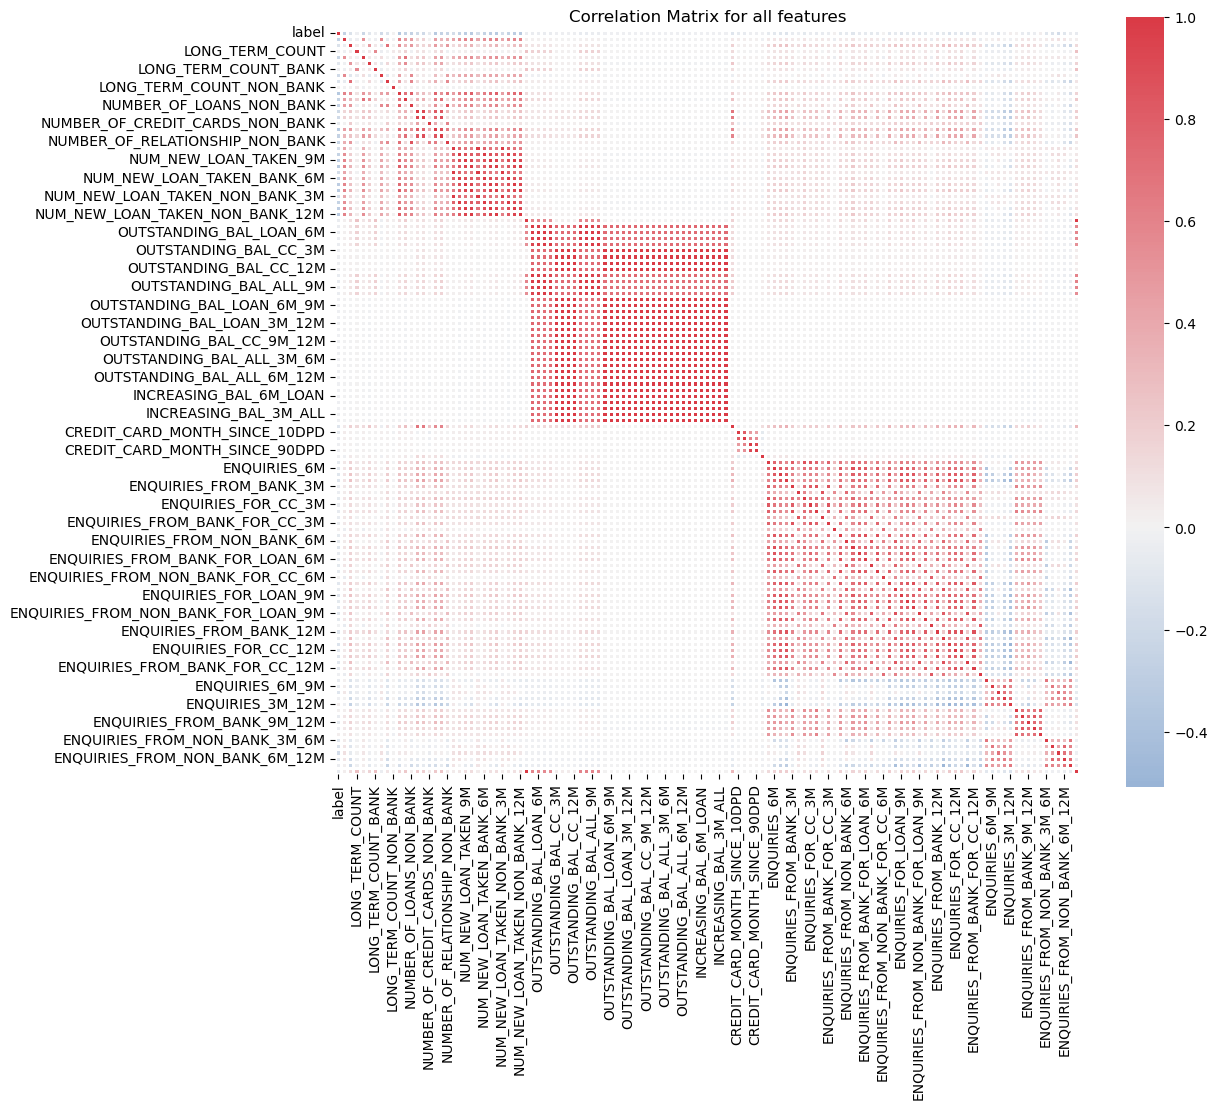

In [5]:
correlation_matrix = df.corr()


plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(correlation_matrix, cmap=cmap, square=True, linewidth=1, center=0)

plt.title('Correlation Matrix for all features')
plt.show()

# Feature Extraction

In [69]:
correlation_with_label = df.corr()['label'].abs().sort_values(ascending=False)

selected_features = correlation_with_label.index[:50]
filtered_df = df[selected_features]

In [70]:
X = filtered_df.drop('label', axis=1)
y = filtered_df['label'] 

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Addressing data imbalance

In [72]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

<Axes: xlabel='label', ylabel='count'>

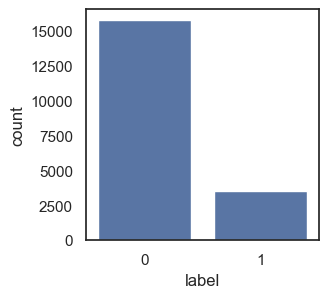

In [73]:
f, ax = plt.subplots(figsize=(3, 3))
sns.countplot(x=y, ax=ax)

In [74]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
undersmpler = RandomUnderSampler(sampling_strategy=0.8)
X_over, y_over = sm.fit_resample(X_train, y_train)
# X_over, y_over = undersmpler.fit_resample(X_over, y_over)

<Axes: xlabel='label', ylabel='count'>

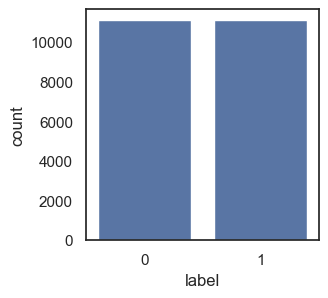

In [75]:
f, ax = plt.subplots(figsize=(3, 3))
sns.countplot(x=y_over, ax=ax)

In [76]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

rfe = RFE(model, n_features_to_select=25) 
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(max_depth=10, n_estimators=200,
                                     random_state=42),
    n_features_to_select=25)

In [77]:
selected_features = X_train.columns[rfe.support_]
print(*selected_features)

NUMBER_OF_LOANS NUMBER_OF_RELATIONSHIP NUM_NEW_LOAN_TAKEN_NON_BANK_12M NUM_NEW_LOAN_TAKEN_BANK_12M NUM_NEW_LOAN_TAKEN_12M NUM_NEW_LOAN_TAKEN_NON_BANK_9M NUM_NEW_LOAN_TAKEN_BANK_9M NUM_NEW_LOAN_TAKEN_9M SHORT_TERM_COUNT NUMBER_OF_LOANS_NON_BANK NUMBER_OF_RELATIONSHIP_BANK NUM_NEW_LOAN_TAKEN_BANK_6M NUMBER_OF_LOANS_BANK NUMBER_OF_RELATIONSHIP_NON_BANK NUMBER_OF_CREDIT_CARDS SHORT_TERM_COUNT_NON_BANK NUMBER_OF_CREDIT_CARDS_BANK MID_TERM_COUNT ENQUIRIES_FOR_LOAN_12M ENQUIRIES_12M OUTSTANDING_BAL_CC_CURRENT ENQUIRIES_9M ENQUIRIES_FOR_LOAN_6M ENQUIRIES_FROM_NON_BANK_FOR_LOAN_12M ENQUIRIES_6M


In [78]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Model Experiment

In [79]:
def plot_custom_confusion_matrix(conf_matrix, title='Seaborn Confusion Matrix with labels'):
    sns.set(style='white')
    
    # Create the figure and the heatmap
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Create heatmap using eye matrix to allow custom colors per cell
    sns.heatmap(
        np.eye(2),  # Identity matrix to create individual cell colors
        annot=conf_matrix,  # Confusion matrix to display actual values
        fmt='g',  # General format for annotations
        annot_kws={'size': 20},  # Annotation font size
        cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True),  # Custom colors
        cbar=False,  # No color bar
        yticklabels=['True', 'False'],  # Actual labels
        xticklabels=['True', 'False'],  # Predicted labels
        ax=ax  # Axis object to use
    )
    
    # Adjust the position of the tick labels
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(labelsize=8, length=0)
    
    # Set axis labels and title
    ax.set_title(title, size=10, pad=20)
    ax.set_xlabel('Predicted Values', size=10)
    ax.set_ylabel('Actual Values', size=10)
    
    # Add additional custom text to the cells
    additional_texts = ['(True Positive)', '(False Negative)', '(False Positive)', '(True Negative)']
    for text_elt, additional_text in zip(ax.texts, additional_texts):
        ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
                ha='center', va='top', size=10)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

## Decision Tree

In [80]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_clf = DecisionTreeClassifier(max_depth=7, max_features='sqrt', random_state=42)

In [81]:
start_time = time.perf_counter()
decision_tree_clf.fit(X_train, y_train)      
end_time = time.perf_counter()

print(f'Training time elapsed: {end_time - start_time} seconds')

Training time elapsed: 0.010101700001541758 seconds


In [82]:
y_train_pred = decision_tree_clf.predict(X_train)
y_pred = decision_tree_clf.predict(X_test)
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred)}")

Train accuracy: 0.8969957081545065
Test accuracy: 0.8806975138121547
Test F1 Score: 0.5527508090614887


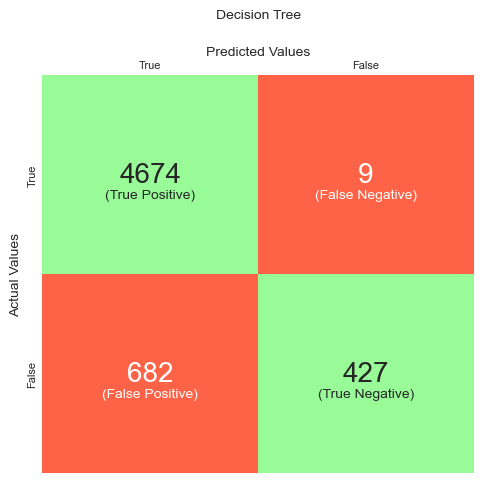

In [83]:
conf_matrix = confusion_matrix(y_test, y_pred)

plot_custom_confusion_matrix(conf_matrix, 'Decision Tree')

## Random Forest

In [84]:
random_forest_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

In [85]:
start_time = time.perf_counter()
random_forest_clf.fit(X_train, y_train)      
end_time = time.perf_counter()

print(f'Training time elapsed: {end_time - start_time} seconds')

Training time elapsed: 1.6359819999997853 seconds


In [86]:
y_train_pred = random_forest_clf.predict(X_train)
y_pred = random_forest_clf.predict(X_test)
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred)}")

Train accuracy: 0.9002515909427261
Test accuracy: 0.8822513812154696
Test F1 Score: 0.5582901554404145


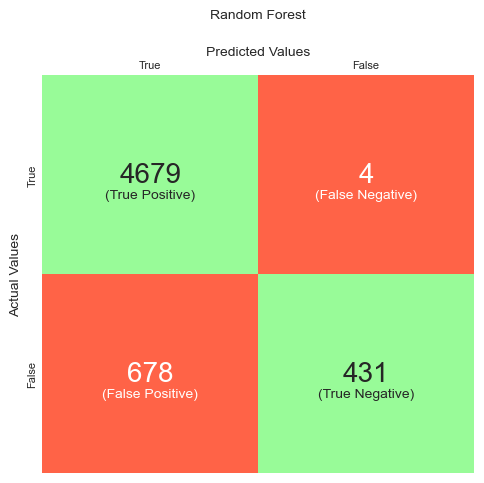

In [87]:
conf_matrix = confusion_matrix(y_test, y_pred)

plot_custom_confusion_matrix(conf_matrix, 'Random Forest')

## XGBoost

In [88]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [94]:
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
neg / pos

4.584297520661157

In [89]:
params = {
    'eta': 0.07,
    'objective': 'multi:softprob',  
    'num_class': 2,
    'device': 'cpu',
    'max_depth': 10,
    'num_parallel_tree': 5,
    'random_state': 42
}
steps = 400

In [90]:
start_time = time.perf_counter()
model = xgb.train(params, D_train, steps)
end_time = time.perf_counter()

print(f'Training time elapsed: {end_time - start_time} seconds')

Training time elapsed: 5.628688799999509 seconds


In [91]:
y_train_pred = np.asarray([np.argmax(line) for line in model.predict(D_train)])
y_pred = np.asarray([np.argmax(line) for line in model.predict(D_test)])

print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred)}")

Train accuracy: 0.9699570815450643
Test accuracy: 0.8786256906077348
Test F1 Score: 0.5721241631162508


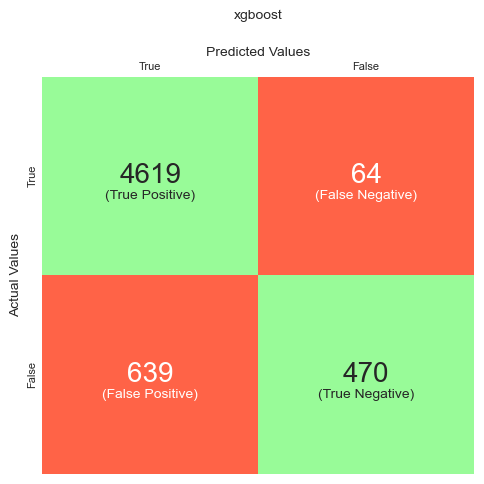

In [92]:
conf_matrix = confusion_matrix(y_test, y_pred)

plot_custom_confusion_matrix(conf_matrix, 'xgboost')